In [29]:
import json
import osmnx as ox
from typing import Tuple, Dict, List
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import networkx as nx
import numpy as np
from shapely.geometry import Point, LineString

# Setting:

The origin of the Helsinki city centre is used to obtain the network of the roads from OpenStreetMap using OSMNX.
A buffer of 1200 m is used to set the bounds of the network.

The selected hobby is `CYCLE`, and characters of this word are used. Each character is mapped as a vector and stored in a `json` file.
The mapping is done like this:

![alt text](img/char_coords.drawio.png)

By using the extends of the obtained graph, the scaling of the vectors and coordinates is calculated. 
I adjusted the values to have a readable result. 

By processing the vectors of each character, the sequence of destinations with a starting point is generated. The final task is to use the network to find the shortest path between these destinations sequentially. 

The result will write our character of interest on the map. 

This code is dynamic. You can change the `HOBBY_STR` parameter to a string of your liking. However, each character in the string should have a valid representation in the `json` file.

In [35]:
# Settings:
HELSINKI_CENTER: Tuple[float, ...] = 60.168548, 24.941506
DISTANCE:int = 1200 # m
CHAR_JSON_FP: Path = Path("data/alphabet.json") # pre-made vectors depicting characters
HOBBY_STR:str = "CYCLE"

with open(file=CHAR_JSON_FP, mode="r") as f:
    CHAR_VECTOR: Dict = json.loads(f.read())

In [36]:
def get_neares_node(pt: Point, G: nx.MultiDiGraph) -> int:
    """Obtains the nearest node of the graph

    Parameters
    ----------
    pt : Point
    G : nx.MultiDiGraph
        This graph must be obtained using OSMNX

    Returns
    -------
    int
        the id of the closest node.
    """    
    node_id: int = ox.distance.nearest_nodes(G, pt.x, pt.y, return_dist=True)[0]
    return node_id


def get_path_line(org: int, dest: int, G: nx.MultiDiGraph) -> LineString:
    """Generating path geometry from origin and destination nodes.

    The path finding algorithm returns the sequence of nodes. 
    This function gets the route node sequence and then converts it
    to Linestring geometry

    Parameters
    ----------
    org : int
        origin node id
    dest : int
        Destination node id
    G : nx.MultiDiGraph
        the Graph made using OSMNX. the nodes must be obtained from using the same graph.

    Returns
    -------
    LineString
        the path geometry.
    """    
    route = ox.shortest_path(G, org, dest, weight="length")
    return LineString([(G.nodes[node]["x"], G.nodes[node]["y"]) for node in route])


In [37]:
# Generating the settings accordingly. 
G = G = ox.graph_from_point(HELSINKI_CENTER, dist=DISTANCE, network_type="all")
network_bounds: List[float] = list(ox.graph_to_gdfs(G, edges=False).total_bounds)
G_width: float = network_bounds[2] - network_bounds[0]  # xmax - xmin
G_height: float = network_bounds[3] - network_bounds[1]  # ymax - ymin

# each character with the spacing is 3 units. hence the times 3 of string length

text_scale: float = float(G_width) / (len(HOBBY_STR)*3)
starting_pt: List[float] = [
    network_bounds[0] + text_scale * 2,
    network_bounds[3] - (G_height /2),
]

In [ ]:
vectors:List = [[0,0]] # we set the starting point as origo.
types:List[str] = ["start"]
for char in HOBBY_STR:
    vectors += [v.get("vec") for k, v in CHAR_VECTOR[char].items()]
    types += [v.get("type") for k, v in CHAR_VECTOR[char].items()]

    
# We are far north, so the distance for Y axis is halved. a projected CRS should resolve this
# The simplified coordinates are scaled according to the calculated scale, and their position is adjusted by the starting point.
destinations: np.array = (
    np.cumsum(np.array(vectors), axis=0) * np.array([text_scale, text_scale/2] )+ starting_pt
)

destinations_gdf: gpd.GeoDataFrame = gpd.GeoDataFrame(
    {"type": types}, geometry=[Point(pt) for pt in destinations], crs=4326
)
# The destinations are sequentially origin and destinations. 
# We set the existing as destination, and the shift as origin. 
# The shift direction is to make sure types are in right location.
destinations_gdf["dest"] = destinations_gdf.geometry.apply(
    lambda r: get_neares_node(r, G)
)
destinations_gdf["orig"] = destinations_gdf["dest"].shift(1)

results: gpd.GeoDataFrame = destinations_gdf.dropna().reset_index(drop=True)
results["geometry"] = results.apply(
    lambda row: get_path_line(row["orig"], row["dest"], G), axis=1
)


## Result

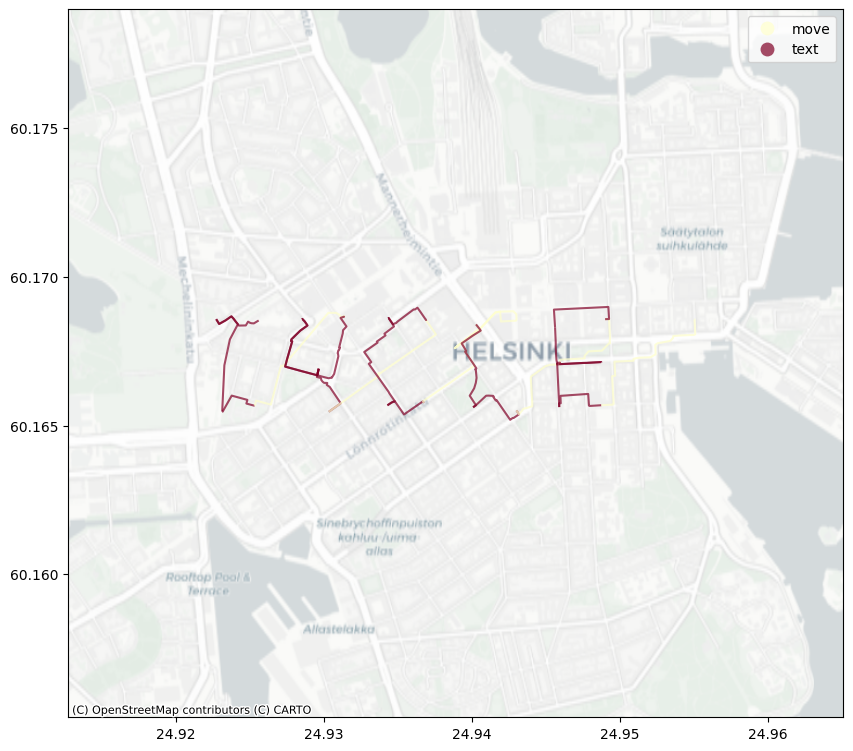

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = results.plot(column="type", alpha=0.7, legend=True, cmap="YlOrRd", ax=ax)

xmin, ymin, xmax, ymax = results.total_bounds

# Expand bounds by a buffer (e.g., 0.01 degrees or units)
buffer = 0.01
ax.set_xlim(xmin - buffer, xmax + buffer)
ax.set_ylim(ymin - buffer, ymax + buffer)
cx.add_basemap(ax, crs=results.crs, source=cx.providers.CartoDB.Positron)